In [1]:
import pandas as pd
import librosa
import librosa.display
import numpy as np
import torch
from models import CustomCNNModel
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader
from dataset import ESC50Dataset,ESC50SpectrogramDataset
import seaborn as sns
from sklearn.metrics import confusion_matrix,roc_curve, auc
from config import FINAL_META_DATA,AUDIO_PATH,BATCH_SIZE,FIG_PATH,MODELS_PATH,RESULTS_PATH

In [2]:
meta_df =  pd.read_csv(FINAL_META_DATA)

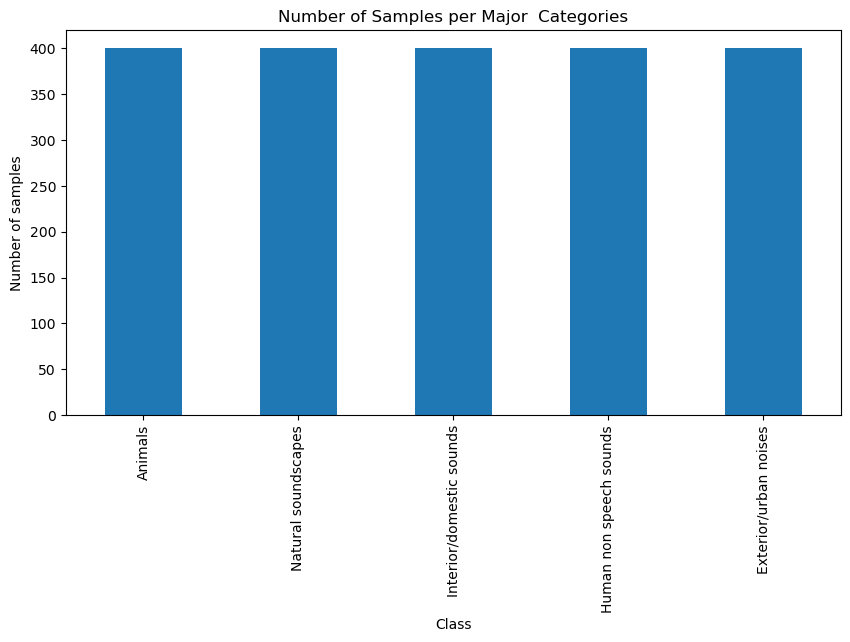

In [3]:
# Make barplot of the number of samples per class
meta_df['category'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Number of Samples per Major  Categories')
plt.savefig(FIG_PATH + '/samples_per_class.png', dpi=300)
plt.show()

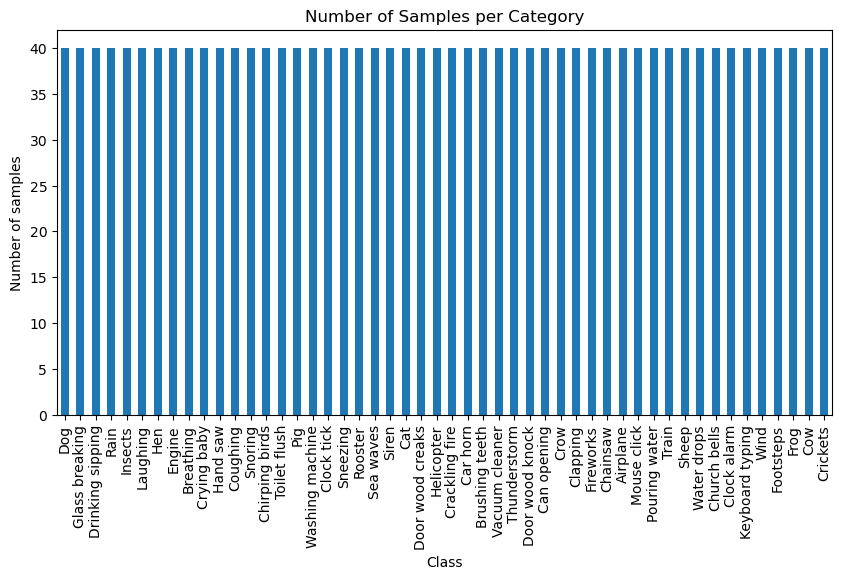

In [5]:
# capitalize the target column
meta_df['target'] = meta_df['target'].str.capitalize()
meta_df['target'].value_counts().plot(kind='bar', figsize=(10, 5) )
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Number of Samples per Category')
plt.savefig(FIG_PATH + '/samples_per_target_class.png', dpi=300)
plt.show()

In [4]:
# Define the dataset and data loader
dataset = ESC50Dataset(csv_file=FINAL_META_DATA, audio_dir=AUDIO_PATH)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
sample,label = next(iter(dataloader))

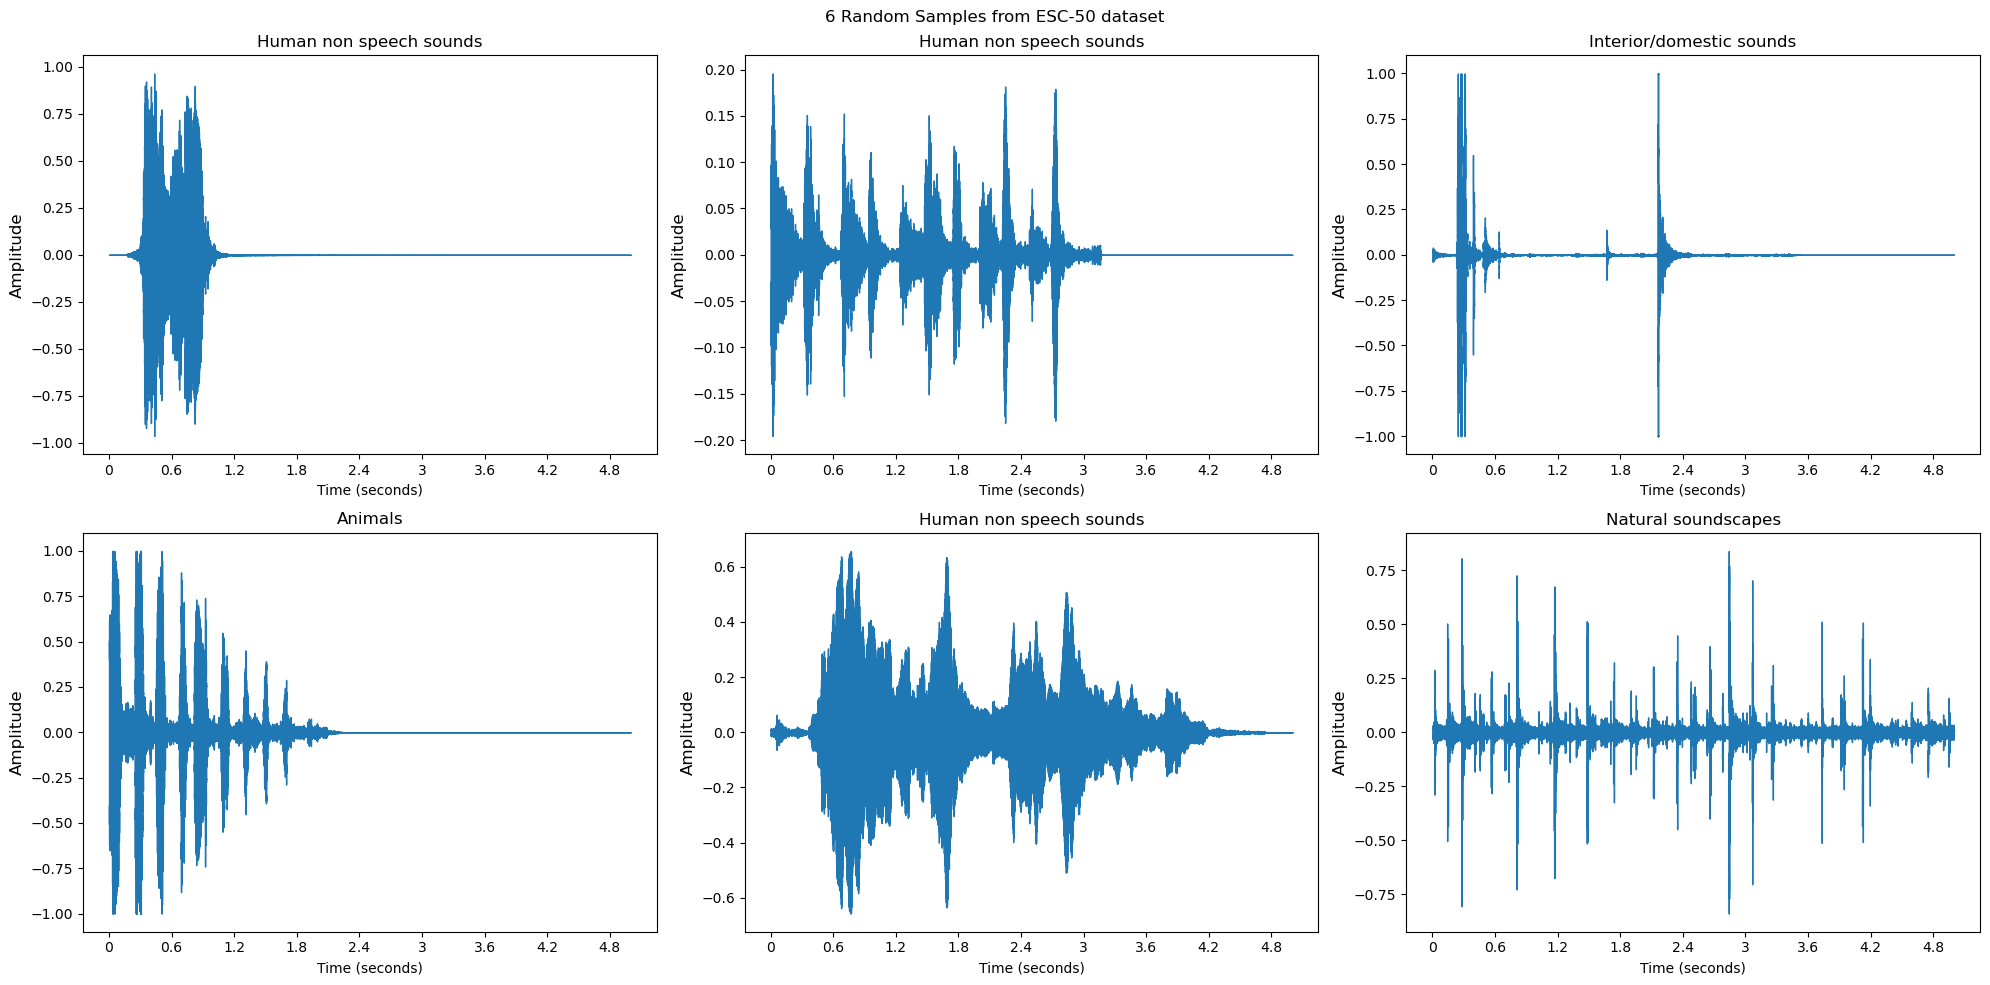

In [5]:
# Plot 6 random samples 
idxs = np.random.randint(0, len(sample['data']), 6)
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('6 Random Samples from ESC-50 dataset')
for i in range(6):
    idx = i % 3
    idy = i // 3
    librosa.display.waveshow(sample['data'][idxs[i]].squeeze().numpy(), sr=44100, ax=ax[idy, idx], axis='s')
    ax[idy, idx].set_title(dataset.get_key_from_value(label[idxs[i]].numpy()), fontsize=12)
    ax[idy, idx].set_ylabel('Amplitude', fontsize=12)
plt.tight_layout()
plt.savefig(FIG_PATH + '/random_waveform_samples.png', dpi=300)

In [6]:
dataset = ESC50SpectrogramDataset(csv_file=FINAL_META_DATA, audio_dir=AUDIO_PATH)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

sample,label = next(iter(dataloader))

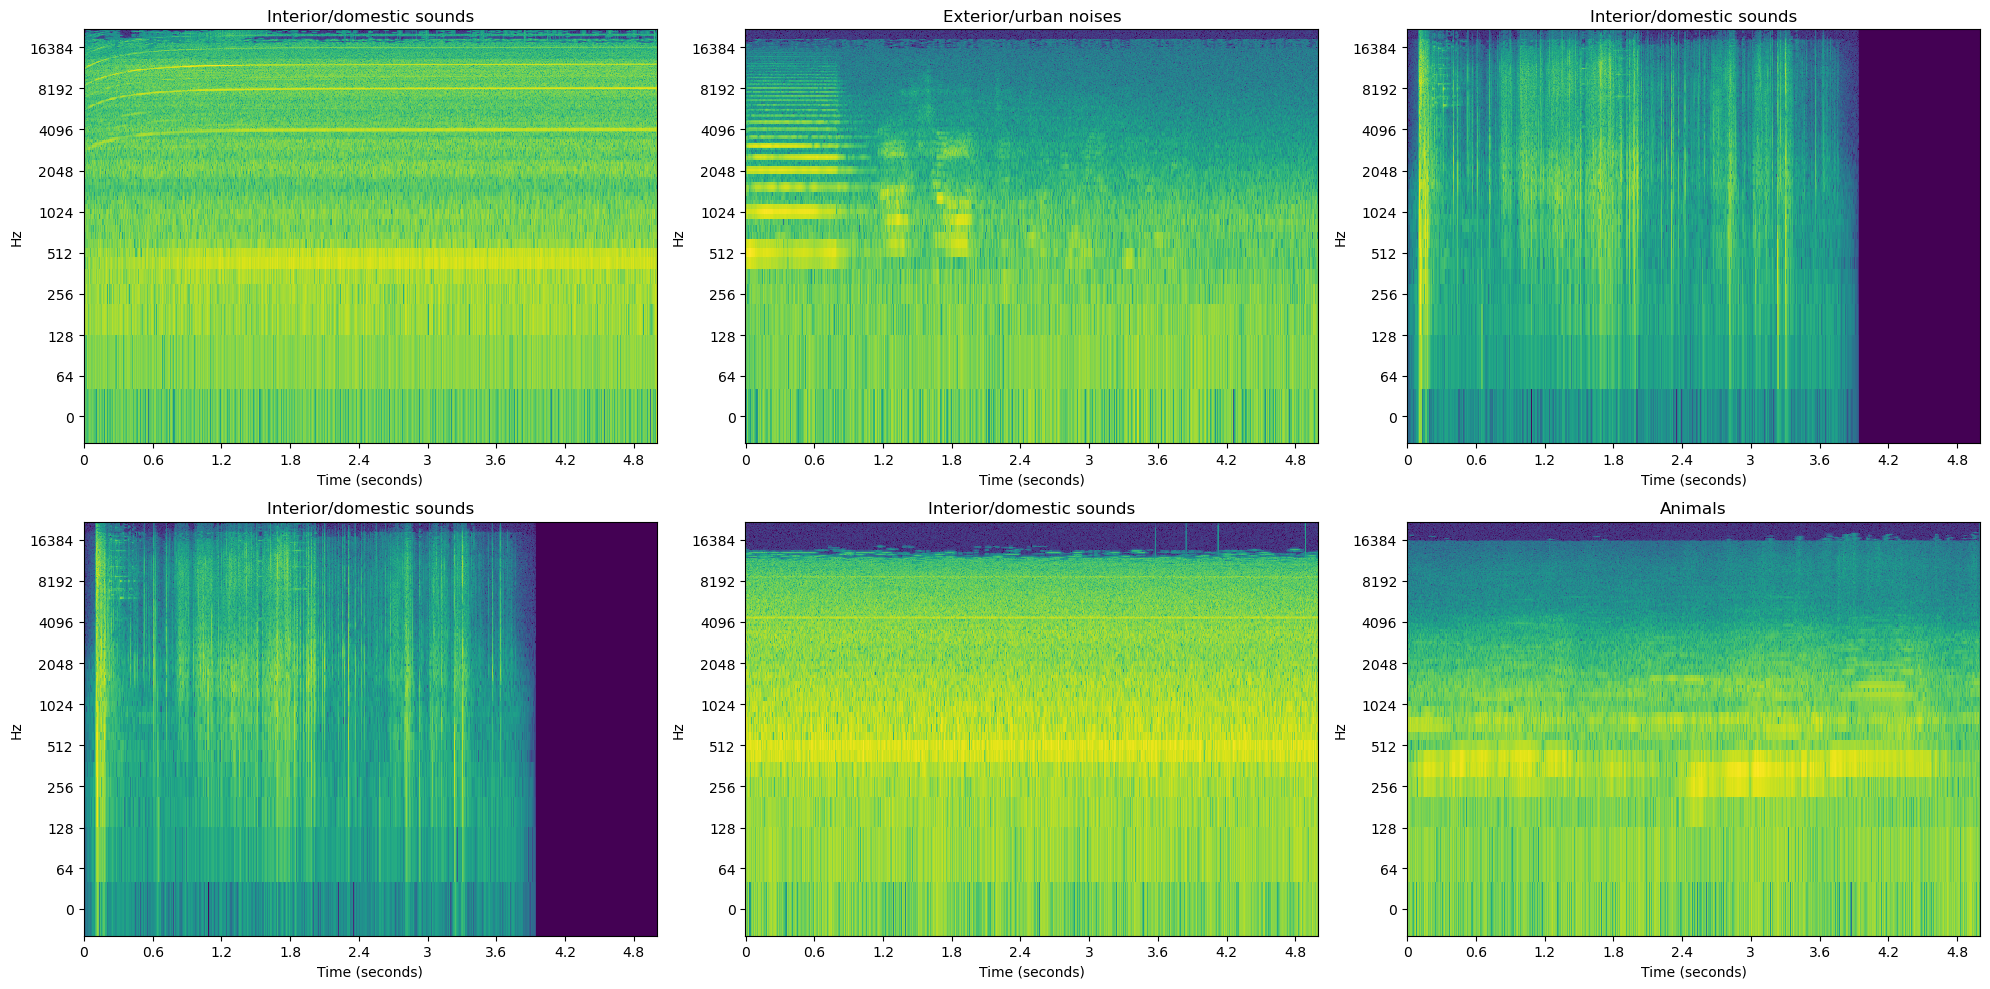

In [7]:
# Plot 6 random samples 
idxs = np.random.randint(0, len(sample['data']), 6)
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
# fig.suptitle('6 Random Samples from ESC-50 dataset')
for i in range(6):
    idx = i % 3
    idy = i // 3
    librosa.display.specshow(sample['data'][idxs[i]].squeeze().numpy(), sr=44100, hop_length=256, ax=ax[idy, idx], x_axis='s', y_axis='log',cmap='viridis')
    ax[idy, idx].set_title(dataset.get_key_from_value(label[idxs[i]].numpy()))
plt.tight_layout()
plt.savefig(FIG_PATH + '/random_log_spectrogram_samples.png', dpi=300)

In [8]:
modelstr = "dense121"

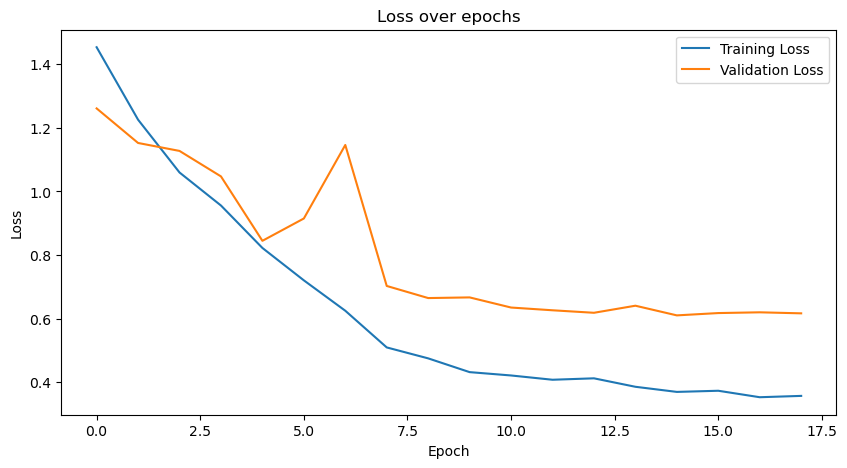

In [9]:
history =  pd.read_csv(f'results/{modelstr}_history.csv')
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.savefig(FIG_PATH + f'/{modelstr}_loss.png', dpi=300)

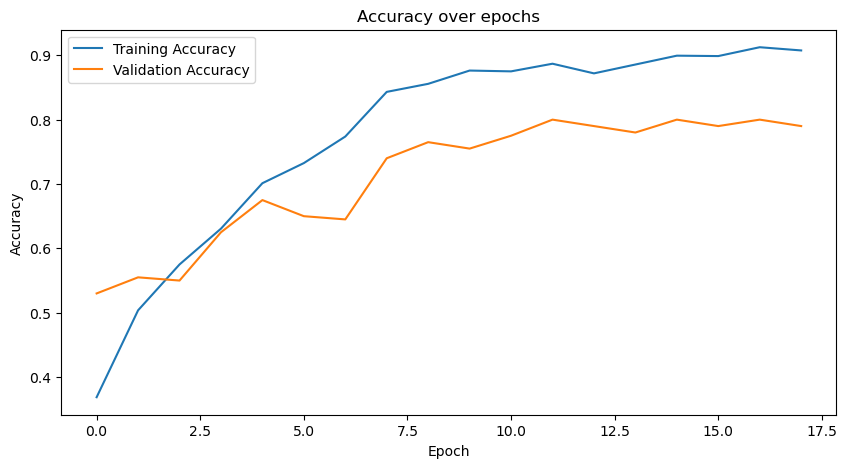

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.savefig(FIG_PATH + f'/{modelstr}_accuracy.png', dpi=300)

In [11]:
# Load the trained model and make predictions
model = CustomCNNModel(num_classes=5, weights=None, modelstr=modelstr)
model.load_state_dict(torch.load(f'{MODELS_PATH}/custom_{modelstr}.pth', map_location=torch.device('cpu')))


<All keys matched successfully>

In [18]:
with torch.inference_mode():
    data = sample['data']
    output = model(data)
    _, predicted = torch.max(output, 1)
    # get the probability of each class
    probabilities = torch.nn.functional.softmax(output, dim=1)
    # get the probability of the predicted class
    predicted_prob = torch.max(probabilities, 1)[0]
    print('Predicted: ', [dataset.get_key_from_value(p.item()) for p in predicted])

Predicted:  ['Interior/domestic sounds', 'Human non speech sounds', 'Exterior/urban noises', 'Animals', 'Exterior/urban noises', 'Natural soundscapes', 'Interior/domestic sounds', 'Exterior/urban noises', 'Animals', 'Natural soundscapes', 'Human non speech sounds', 'Human non speech sounds', 'Human non speech sounds', 'Animals', 'Human non speech sounds', 'Interior/domestic sounds', 'Interior/domestic sounds', 'Natural soundscapes', 'Natural soundscapes', 'Animals', 'Animals', 'Interior/domestic sounds', 'Exterior/urban noises', 'Human non speech sounds', 'Interior/domestic sounds', 'Natural soundscapes', 'Human non speech sounds', 'Animals', 'Animals', 'Exterior/urban noises', 'Interior/domestic sounds', 'Animals']


In [19]:
# Plot six random samples with their predictions 
idxs = np.random.randint(0, len(sample['data']), 6)

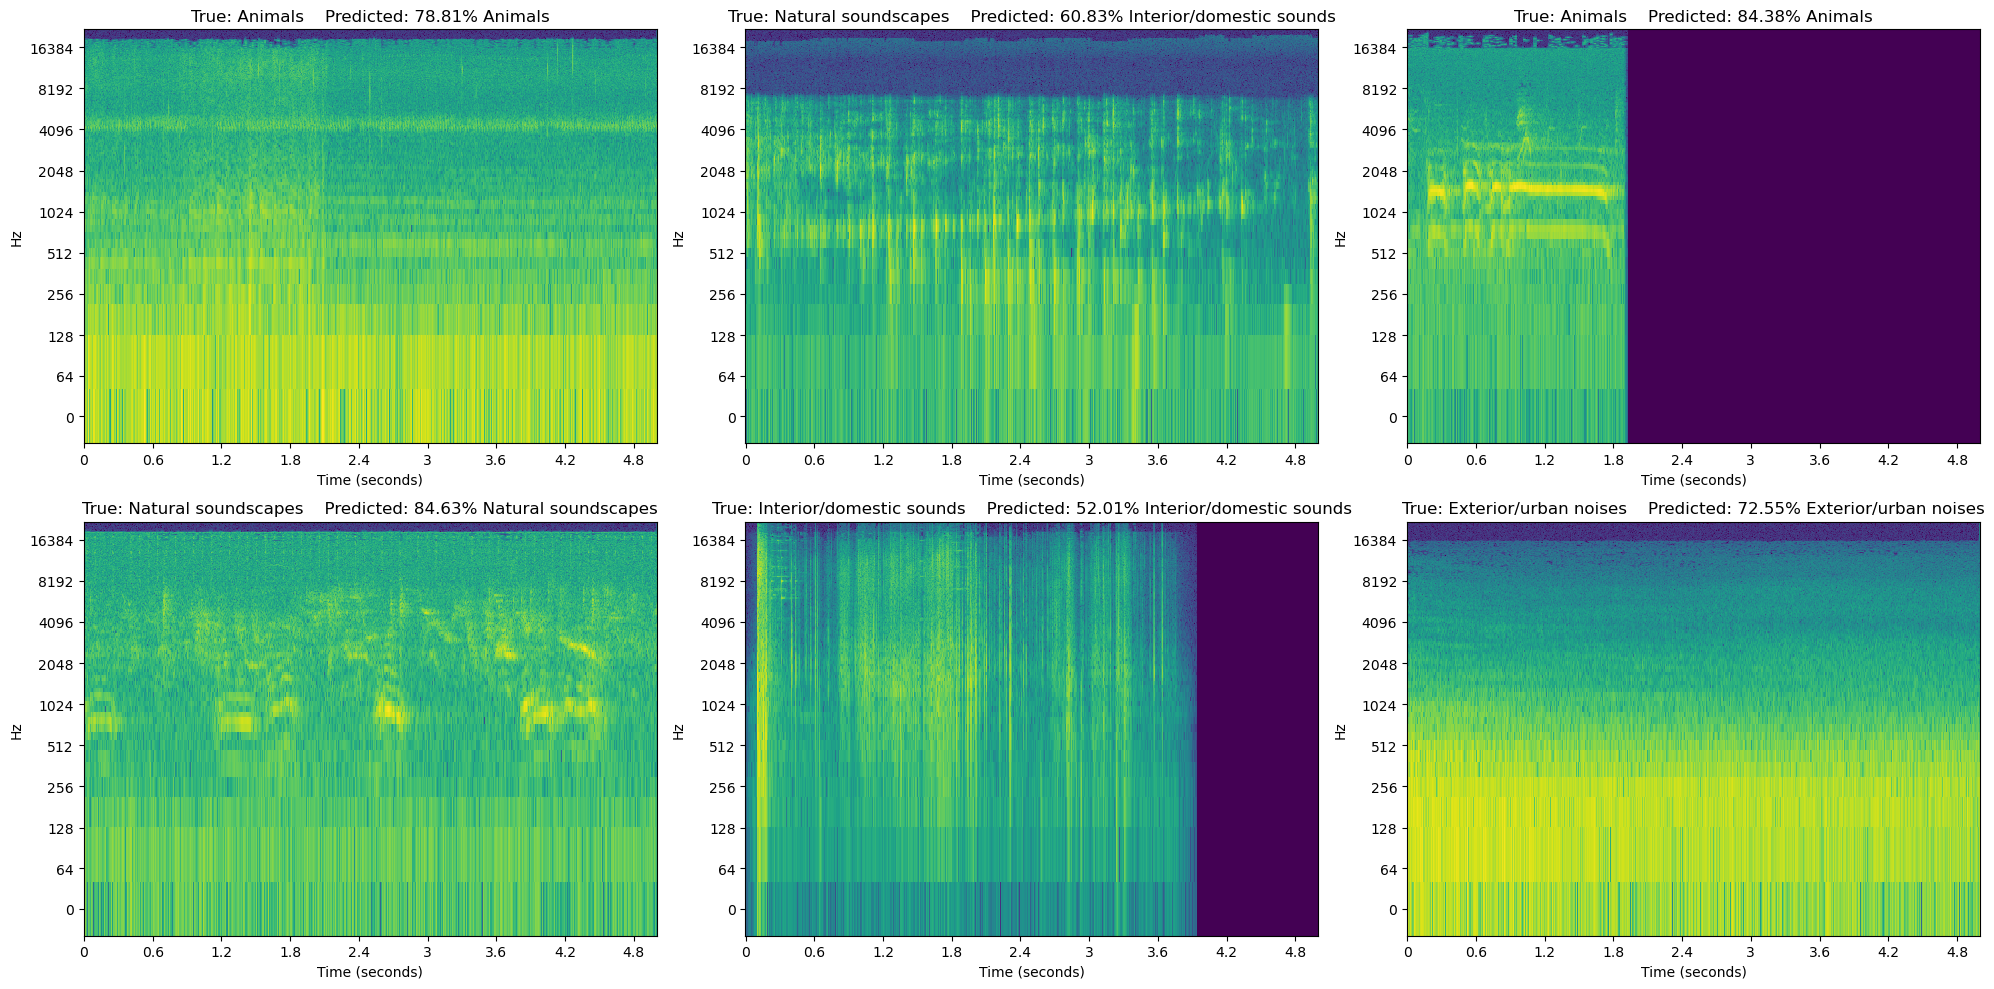

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
# fig.suptitle('6 Random Samples from ESC-50 dataset')
for i in range(6):
    idx = i % 3
    idy = i // 3
    librosa.display.specshow(sample['data'][idxs[i]].squeeze().numpy(), sr=44100, hop_length=256, ax=ax[idy, idx], x_axis='s', y_axis='log',cmap='viridis')
    ax[idy, idx].set_title(f'True: {dataset.get_key_from_value(label[idxs[i]])}    Predicted: {np.round(predicted_prob[idxs[i]].item() *100, 2)}% {dataset.get_key_from_value(predicted[idxs[i]].item())}')
plt.tight_layout()
plt.savefig(FIG_PATH + '/random_log_spectrogram_samples_predictions.png', dpi=300)
plt.show()

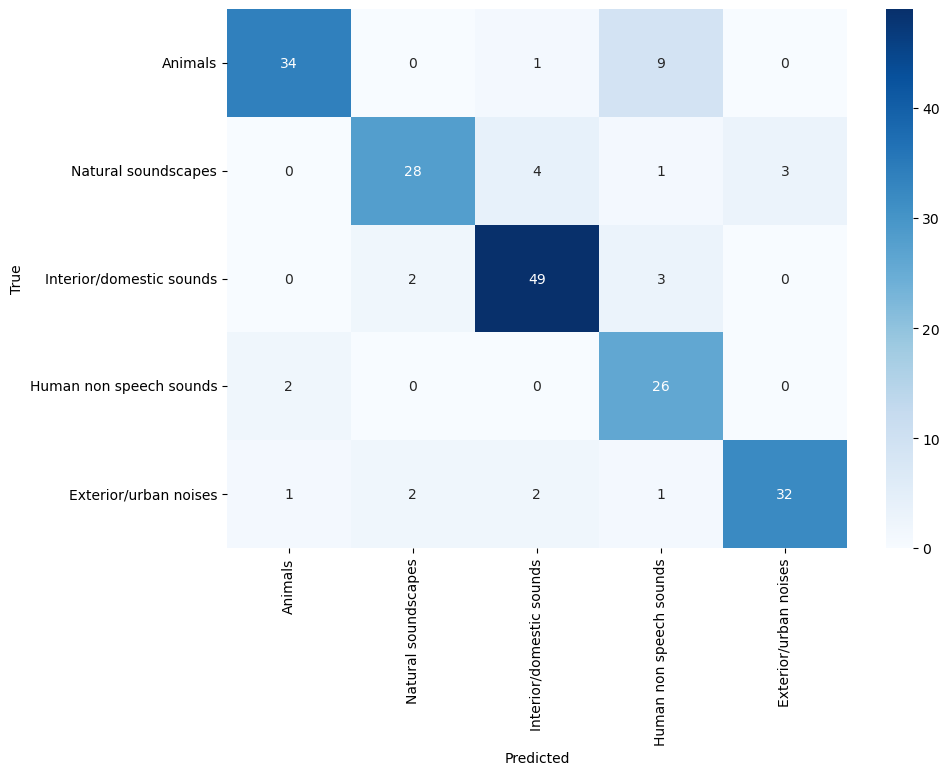

In [21]:
# Plot confusion matrix 
df =  pd.read_csv(f"{RESULTS_PATH}/{modelstr}_test_scores.csv")

true_labels = df['labels']
pred_labels = df['preds']
class_names = dataset.CLASSES

cm = confusion_matrix(true_labels, pred_labels)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(f'{FIG_PATH}/{modelstr}_confusion_matrix.png', dpi=300)
plt.show()


## Analysis for ResNet18

In [22]:
modelstr = "resnet18"

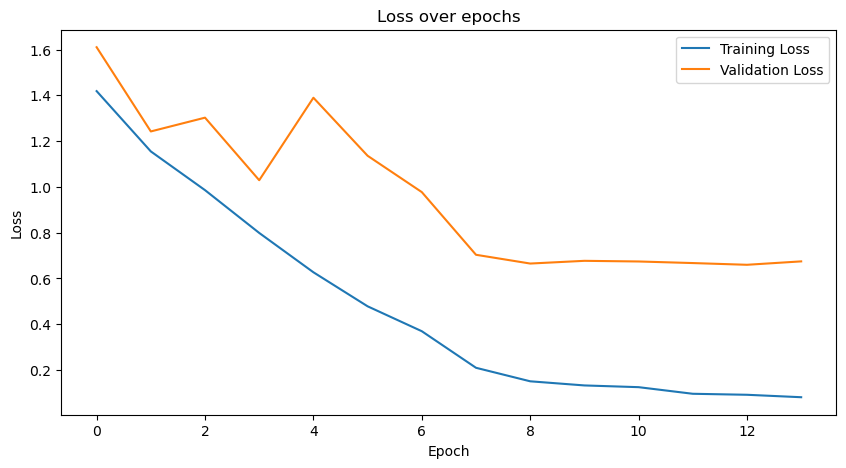

In [23]:
history =  pd.read_csv(f'results/{modelstr}_history.csv')
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.savefig(FIG_PATH + f'/{modelstr}_loss.png', dpi=300)

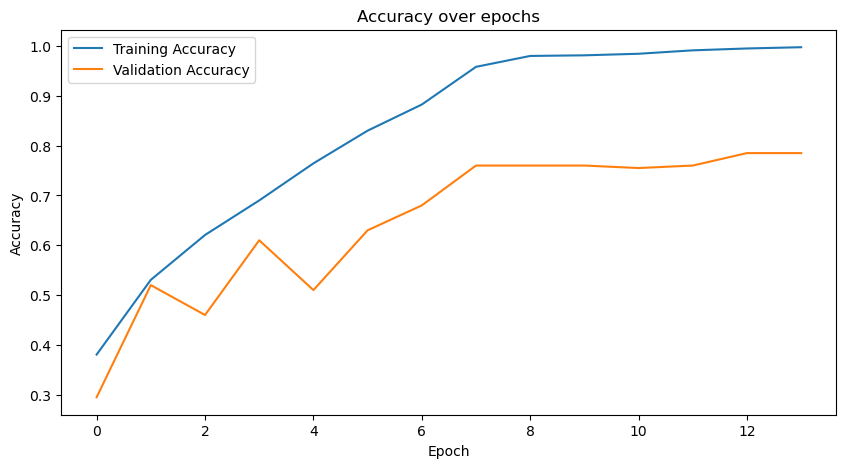

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.savefig(FIG_PATH + f'/{modelstr}_accuracy.png', dpi=300)

In [25]:
# Load the trained model and make predictions
model = CustomCNNModel(num_classes=5, weights=None, modelstr=modelstr)
model.load_state_dict(torch.load(f'{MODELS_PATH}/custom_{modelstr}.pth', map_location=torch.device('cpu')))


with torch.inference_mode():
    data = sample['data']
    output = model(data)
    _, predicted = torch.max(output, 1)
    # get the probability of each class
    probabilities = torch.nn.functional.softmax(output, dim=1)
    # get the probability of the predicted class
    predicted_prob = torch.max(probabilities, 1)[0]
    print('Predicted: ', [dataset.get_key_from_value(p.item()) for p in predicted])

Predicted:  ['Exterior/urban noises', 'Human non speech sounds', 'Exterior/urban noises', 'Animals', 'Human non speech sounds', 'Natural soundscapes', 'Interior/domestic sounds', 'Exterior/urban noises', 'Animals', 'Natural soundscapes', 'Human non speech sounds', 'Human non speech sounds', 'Human non speech sounds', 'Animals', 'Animals', 'Interior/domestic sounds', 'Natural soundscapes', 'Natural soundscapes', 'Natural soundscapes', 'Animals', 'Animals', 'Interior/domestic sounds', 'Exterior/urban noises', 'Human non speech sounds', 'Human non speech sounds', 'Natural soundscapes', 'Human non speech sounds', 'Animals', 'Animals', 'Exterior/urban noises', 'Natural soundscapes', 'Animals']


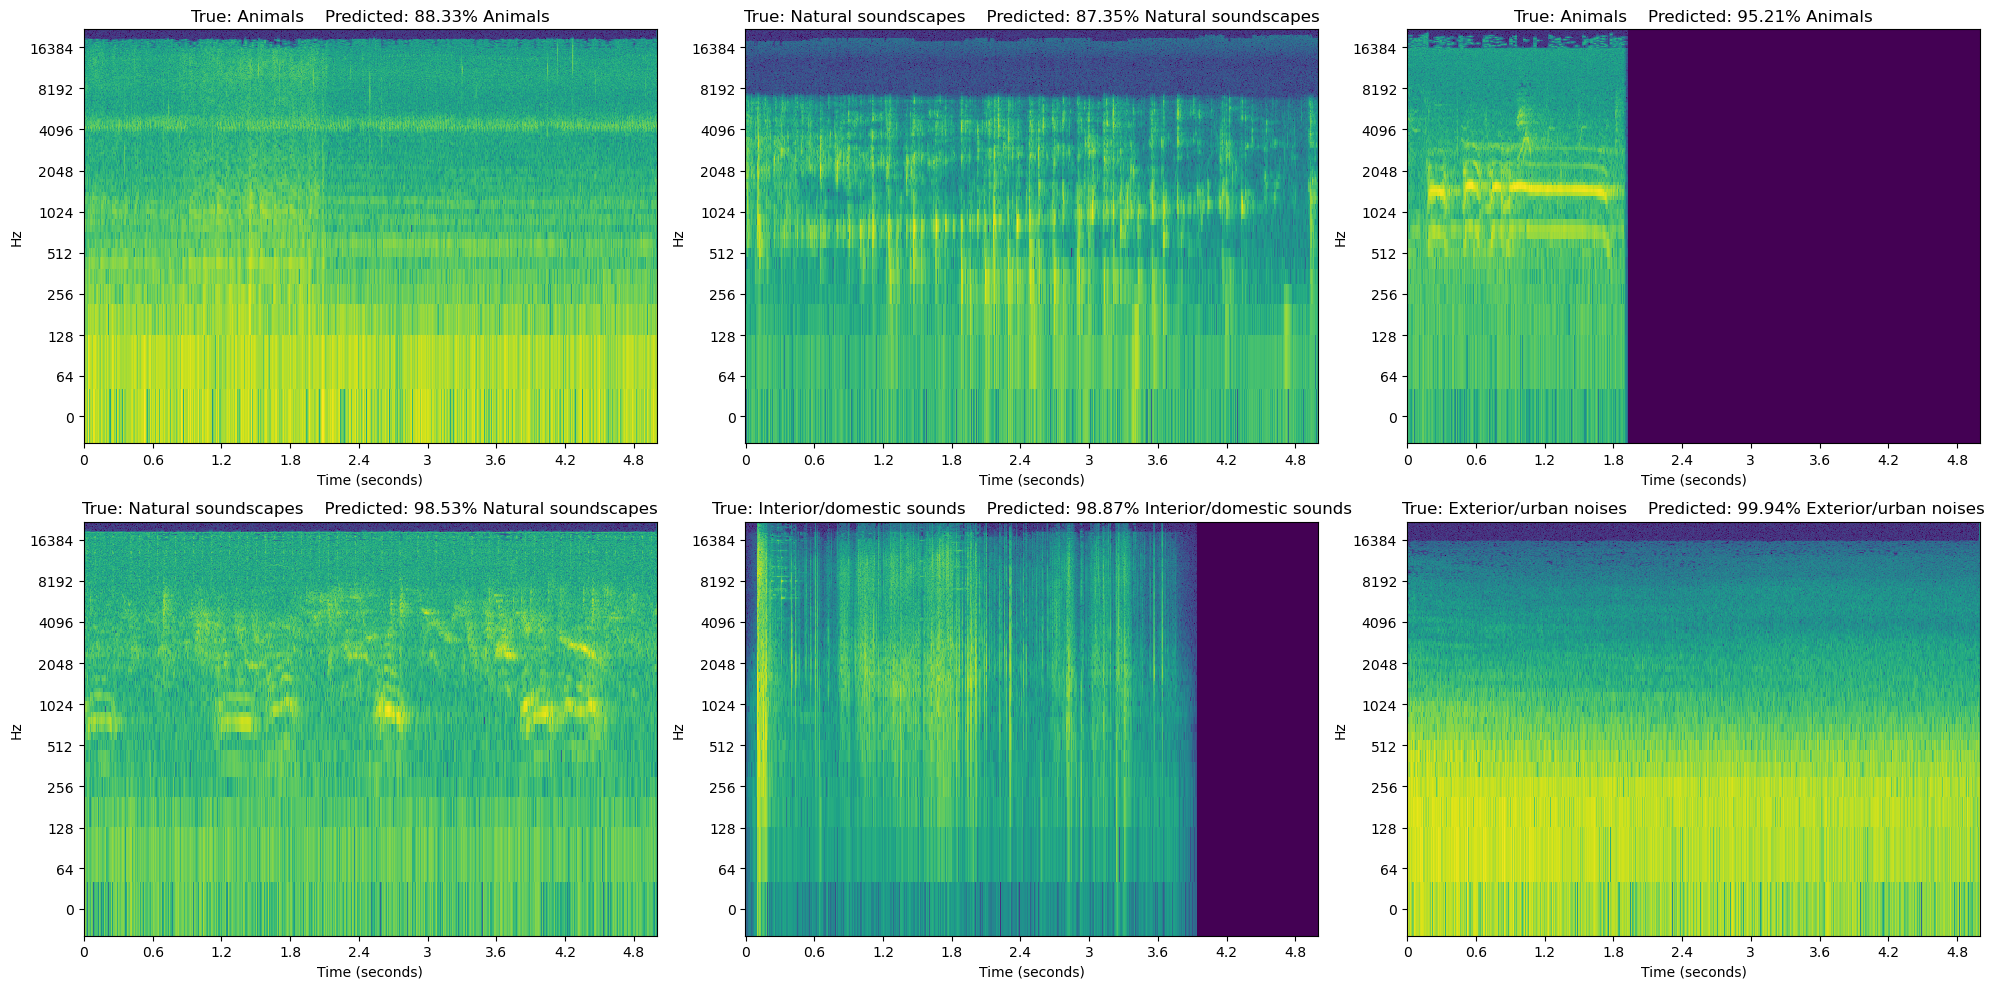

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
# fig.suptitle('6 Random Samples from ESC-50 dataset')
for i in range(6):
    idx = i % 3
    idy = i // 3
    librosa.display.specshow(sample['data'][idxs[i]].squeeze().numpy(), sr=44100, hop_length=256, ax=ax[idy, idx], x_axis='s', y_axis='log',cmap='viridis')
    ax[idy, idx].set_title(f'True: {dataset.get_key_from_value(label[idxs[i]])}    Predicted: {np.round(predicted_prob[idxs[i]].item() *100, 2)}% {dataset.get_key_from_value(predicted[idxs[i]].item())}')
plt.tight_layout()
plt.savefig(FIG_PATH + f'/{modelstr}_random_log_spectrogram_samples_predictions.png', dpi=300)
plt.show()

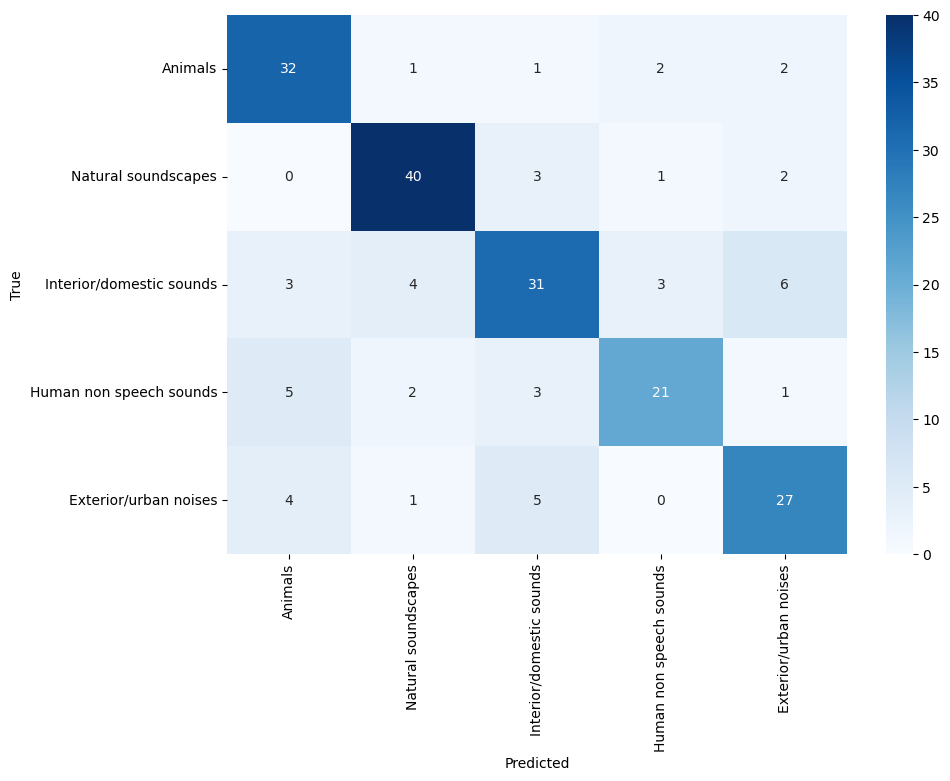

In [43]:
# Plot confusion matrix 
df =  pd.read_csv(f"{RESULTS_PATH}/{modelstr}_test_scores.csv")

true_labels = df['labels']
pred_labels = df['preds']
class_names = dataset.CLASSES

cm = confusion_matrix(true_labels, pred_labels)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(f'{FIG_PATH}/{modelstr}_confusion_matrix.png', dpi=300)
plt.show()


## Analysis for EfficientNetB0

In [59]:
modelstr = "efficientnet_b0"

In [ ]:
history =  pd.read_csv(f'results/{modelstr}_history.csv')
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.savefig(FIG_PATH + f'/{modelstr}_loss.png', dpi=300)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.savefig(FIG_PATH + f'/{modelstr}_accuracy.png', dpi=300)

In [ ]:
# Load the trained model and make predictions
model = CustomCNNModel(num_classes=5, weights=None, modelstr=modelstr)
model.load_state_dict(torch.load(f'{MODELS_PATH}/custom_{modelstr}.pth', map_location=torch.device('cpu')))


with torch.inference_mode():
    data = sample['data']
    output = model(data)
    _, predicted = torch.max(output, 1)
    # get the probability of each class
    probabilities = torch.nn.functional.softmax(output, dim=1)
    # get the probability of the predicted class
    predicted_prob = torch.max(probabilities, 1)[0]
    print('Predicted: ', [dataset.get_key_from_value(p.item()) for p in predicted])

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
# fig.suptitle('6 Random Samples from ESC-50 dataset')
for i in range(6):
    idx = i % 3
    idy = i // 3
    librosa.display.specshow(sample['data'][idxs[i]].squeeze().numpy(), sr=44100, hop_length=256, ax=ax[idy, idx], x_axis='s', y_axis='log',cmap='viridis')
    ax[idy, idx].set_title(f'True: {dataset.get_key_from_value(label[idxs[i]])}    Predicted: {np.round(predicted_prob[idxs[i]].item() *100, 2)}% {dataset.get_key_from_value(predicted[idxs[i]].item())}')
plt.tight_layout()
plt.savefig(FIG_PATH + f'/{modelstr}_random_log_spectrogram_samples_predictions.png', dpi=300)
plt.show()

In [ ]:
# Plot confusion matrix 
df =  pd.read_csv(f"{RESULTS_PATH}/{modelstr}_test_scores.csv")

true_labels = df['labels']
pred_labels = df['preds']
class_names = dataset.CLASSES

cm = confusion_matrix(true_labels, pred_labels)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(f'{FIG_PATH}/{modelstr}_confusion_matrix.png', dpi=300)
plt.show()
